In [1]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.io as pio
import SimpleITK as sitk
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import os
import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from tqdm import tqdm

sns.set(font_scale=1.5)

pd.set_option('display.max_columns', 100)
plt.rcParams["font.size"] = 18
plt.rcParams["font.weight"] = 800

In [4]:
df2=pd.read_csv('../output/csv/se2_each_cid_hist.csv')
df3=pd.read_csv('../output/csv/se3_each_cid_hist.csv')

In [5]:
def KLD(a_hist, b_hist, bins=10, epsilon=.00001):
    # サンプルをヒストグラムに, 共に同じ数のビンで区切る

    # 合計を1にするために全合計で割る
    a_hist = (a_hist+epsilon)/np.sum(a_hist)
    b_hist = (b_hist+epsilon)/np.sum(b_hist)
    
    # 本来なら a の分布に0が含まれているなら0, bの分布に0が含まれているなら inf にする
    return np.sum([ai * np.log(ai / bi) for ai, bi in zip(a_hist, b_hist)])

In [108]:
'''
時相を混ぜて、最もKLDが一番小さくなるところを求める。
-749~749のCTのヒストグラムから決める
0.01刻みで計る
ratio_numの値
-100…-SE2+2SE3
0...SE3
100...SE2
200...2SE2+SE3
'''
kldf2=pd.DataFrame(columns=['pred_kld','kld','ratio_num','cid'])
kldf3=pd.DataFrame(columns=['pred_kld','kld','ratio_num','cid'])


mean2=df2.iloc[:,1:1499].mean().values
mean3=df3.iloc[:,1:1499].mean().values
hist2=df2.iloc[0,1:1499].values
hist3=df3.iloc[0,1:1499].values
kld2=np.inf
kld3=np.inf

for h in tqdm(df2.index):
    hist2=df2.iloc[h,1:1499].values
    hist3=df3.iloc[h,1:1499].values
    kld2=np.inf
    kld3=np.inf
    kldf2.loc[h,['pred_kld','cid']]=[KLD(mean2,hist2),df2.loc[h,'cid']]
    kldf3.loc[h,['pred_kld','cid']]=[KLD(mean3,hist3),df3.loc[h,'cid']]
    tmp_kld3=KLD(mean3,hist3)
    for i in range(-100,200):
        mix=(hist2*0.01*i)+(hist3*0.01*(100-i))
        tmp_kld2=KLD(mean2,mix)
        tmp_kld3=KLD(mean3,mix)
        tmp_kld2=tmp_kld2 if tmp_kld2!=np.nan else np.inf
        tmp_kld3=tmp_kld3 if tmp_kld3!=np.nan else np.inf
        if tmp_kld2<kld2:
            kld2=tmp_kld2
            kldf2.loc[h,['kld','ratio_num']]=[kld2,i]
        
        if tmp_kld3<kld3:
            kld3=tmp_kld3
            kldf3.loc[h,['kld','ratio_num']]=[kld3,i]

  0%|          | 0/113 [00:00<?, ?it/s]/home/kakeya/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning:

invalid value encountered in log

100%|██████████| 113/113 [02:09<00:00,  1.15s/it]


In [115]:
#kldf2=kldf2.merge(kldf3,on='cid',suffixes=('_2','_3'))
#kldf2.to_csv('../output/csv/KLD_params.csv')

In [6]:
kldf=pd.read_csv('../output/csv/KLD_params.csv')

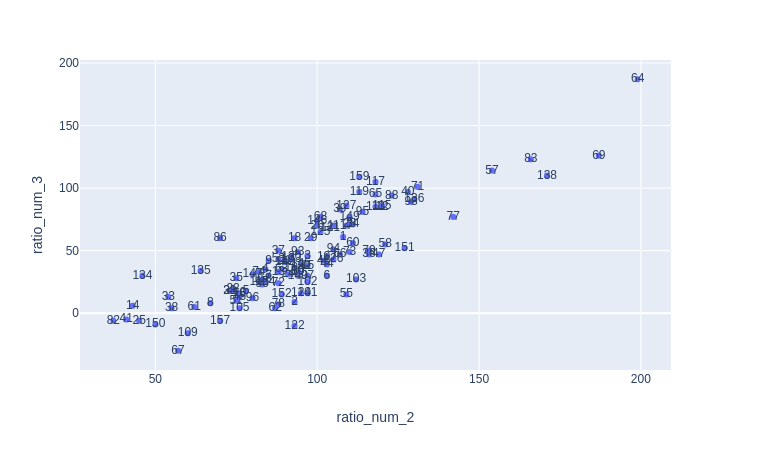

In [138]:
px.scatter(kldf,x='ratio_num_2',y='ratio_num_3',text='cid')

### making batch

In [7]:
def _read_niigz(path:Path)->np.array:
    if os.path.isfile(path):
        data = sitk.ReadImage(str(path))
        return sitk.GetArrayFromImage(data)
    else:
        print(f'Not Found {path}')
        return np.zeros((10,10,10))

In [8]:
candidate_list=[  '001','002','003','004','005','006','007','008','009','010',
   '011','012','013','014','015','017','018','019','021',
   '022','023','024','025','026','028','029','030','031','032',
   '033','034','035','036','037','038','039','040','041','044',
   '045','046','047','051','053','055','057','058','060','061',
   '062','063','064','065','066','067','068','069','071','072',
   '073','074','076','077','078','079','082','083','086','088',
   '090','093','094','095','096','097','098','101','102','103',
   '104','105','107','109','112','113','115','117','118','119',
   '121','122','123','124','125','126','127','130','134','135',
   '136','138','140','142','145','146','147','149','150','151',
   '152','154','157','159'
]
for cid in tqdm(candidate_list):
    cid_path=Path(f'/home/kakeya/Desktop/higuchi/data/00{cid}')
    ccrcc_path=cid_path/'CCRCC.nii.gz'
    kidney_path=cid_path/'kidney.nii.gz'
    se2_path=cid_path/'SE2.nii.gz'
    se3_path=cid_path/'SE3.nii.gz'
    kld_se2_path=cid_path/'kld_SE2.nii.gz'
    kld_se3_path=cid_path/'kld_SE3.nii.gz'

    se3=_read_niigz(se3_path)
    se2=_read_niigz(se2_path)
    #kidney=_read_niigz(kidney_path)
    #ccrcc=_read_niigz(ccrcc_path)

    se2 = np.clip(se2, -768, 768)
    se3 = np.clip(se3, -768, 768)

    ratio2=kldf.loc[kldf['cid']==int(cid),['ratio_num_2']].values
    ratio3=kldf.loc[kldf['cid']==int(cid),['ratio_num_3']].values

    new_se3=(se2*0.01*ratio3+se3*0.01*(100-ratio3)).astype(np.int16)
    new_se2=(se2*0.01*ratio2+se3*0.01*(100-ratio2)).astype(np.int16)

    new_se2=sitk.GetImageFromArray(new_se2)
    new_se3=sitk.GetImageFromArray(new_se3)

    sitk.WriteImage(new_se2,str(kld_se2_path),True)
    sitk.WriteImage(new_se3,str(kld_se3_path),True)

100%|██████████| 1/1 [00:05<00:00,  5.34s/it]


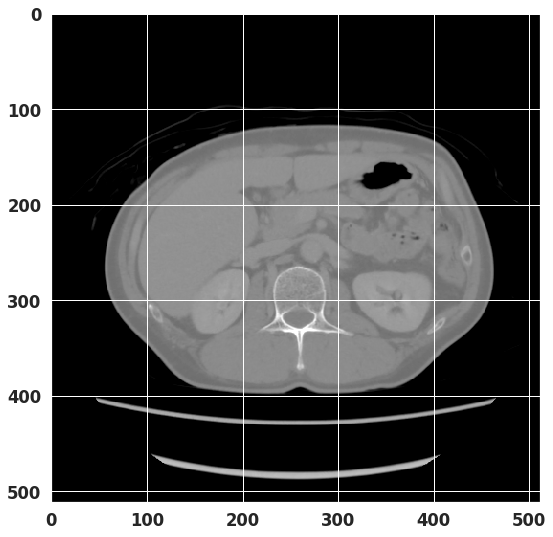

In [153]:
plt.figure(figsize=(9,9))
plt.imshow(se3[se3.shape[0]//2,:,:],'gray')

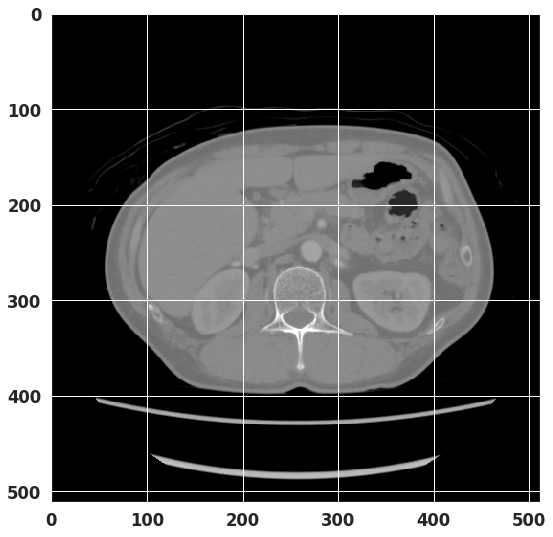

In [160]:
plt.figure(figsize=(9,9))
plt.imshow((se3[se3.shape[0]//2,:,:]*0.3+se2[se2.shape[0]//2,:,:]*0.7).astype(int),'gray')

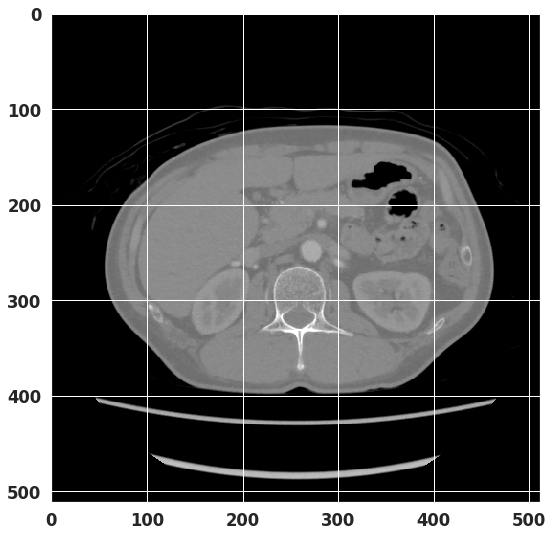

In [174]:
plt.figure(figsize=(9,9))
plt.imshow(se2[se2.shape[0]//2,:,:],'gray')